## Loading Essentials and Helper Functions

In [2]:
import os
from pathlib import Path

In [3]:
# import libraries
import time
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot the graph
import seaborn as sns

# Sklearn classes
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
)
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 17
random.seed(SEED)

In [4]:
OUT_CSV = Path('mushroom_structured.csv')

colnames = [
    'poisonous', 'cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor',
    'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 'stalk_shape',
    'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring',
    'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color',
    'ring_number', 'ring_type', 'spore_print_color', 'population', 'habitat',
 ]

data = pd.read_csv('mushroom/agaricus-lepiota.data', sep=",", header=None, names=colnames, skipinitialspace=True)

#removing na values. This dataset has ? in place of None, so we need to replace those values
data.replace("?", np.nan, inplace=True)
data = data.dropna()
data.head()

,poisonous,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5644 entries, 0 to 8114
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   poisonous                 5644 non-null   object
 1   cap_shape                 5644 non-null   object
 2   cap_surface               5644 non-null   object
 3   cap_color                 5644 non-null   object
 4   bruises                   5644 non-null   object
 5   odor                      5644 non-null   object
 6   gill_attachment           5644 non-null   object
 7   gill_spacing              5644 non-null   object
 8   gill_size                 5644 non-null   object
 9   gill_color                5644 non-null   object
 10  stalk_shape               5644 non-null   object
 11  stalk_root                5644 non-null   object
 12  stalk_surface_above_ring  5644 non-null   object
 13  stalk_surface_below_ring  5644 non-null   object
 14  stalk_color_above_ring    564

In [6]:
data.shape

(5644, 23)

In [7]:
mappings = {}

# Target mapping
mappings['poisonous'] = {'p': True, 'e': False}

# cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
mappings['cap_shape'] = {'b':'bell','c':'conical','x':'convex','f':'flat','k':'knobbed','s':'sunken'}
# cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
mappings['cap_surface'] = {'f':'fibrous','g':'grooves','y':'scaly','s':'smooth'}
# cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
mappings['cap_color'] = {'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow'}
# bruises: bruises=t,no=f
mappings['bruises'] = {'t':'has_bruises','f':'no_bruises'}
# odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
mappings['odor'] = {'a':'almond','l':'anise','c':'creosote','y':'fishy','f':'foul','m':'musty','n':'none','p':'pungent','s':'spicy'}
# gill-attachment: attached=a,descending=d,free=f,notched=nat
mappings['gill_attachment'] = {'a':'attached','d':'descending','f':'free','n':'notched'}
# gill-spacing: close=c,crowded=w,distant=d
mappings['gill_spacing'] = {'c':'close','w':'crowded','d':'distant'}
# gill-size: broad=b,narrow=n
mappings['gill_size'] = {'b':'broad','n':'narrow'}
# gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
mappings['gill_color'] = {'k':'black','n':'brown','b':'buff','h':'chocolate','g':'gray','r':'green','o':'orange','p':'pink','u':'purple','e':'red','w':'white','y':'yellow'}
# stalk-shape: enlarging=e,tapering=t
mappings['stalk_shape'] = {'e':'enlarging','t':'tapering'}
# stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
mappings['stalk_root'] = {'b':'bulbous','c':'club','u':'cup','e':'equal','z':'rhizomorphs','r':'rooted'}
# stalk-surface-above-ring/below-ring: fibrous=f,scaly=y,silky=k,smooth=s
mappings['stalk_surface_above_ring'] = {'f':'fibrous','y':'scaly','k':'silky','s':'smooth'}
mappings['stalk_surface_below_ring'] = mappings['stalk_surface_above_ring']
# stalk-color-above-ring / below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
mappings['stalk_color_above_ring'] = {'n':'brown','b':'buff','c':'cinnamon','g':'gray','o':'orange','p':'pink','e':'red','w':'white','y':'yellow'}
mappings['stalk_color_below_ring'] = mappings['stalk_color_above_ring']
# veil-type: partial=p,universal=u
mappings['veil_type'] = {'p':'partial','u':'universal'}
# veil-color: brown=n,orange=o,white=w,yellow=y
mappings['veil_color'] = {'n':'brown','o':'orange','w':'white','y':'yellow'}
# ring-number: none=n,one=o,two=t
mappings['ring_number'] = {'n': 0,'o': 1,'t': 2}
# ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
mappings['ring_type'] = {'c':'cobwebby','e':'evanescent','f':'flaring','l':'large','n':'none','p':'pendant','s':'sheathing','z':'zone'}
# spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
mappings['spore_print_color'] = {'k':'black','n':'brown','b':'buff','h':'chocolate','r':'green','o':'orange','u':'purple','w':'white','y':'yellow'}
# population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
mappings['population'] = {'a':'abundant','c':'clustered','n':'numerous','s':'scattered','v':'several','y':'solitary'}
# habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d
mappings['habitat'] = {'g':'grasses','l':'leaves','m':'meadows','p':'paths','u':'urban','w':'waste','d':'woods'}

# Check mapping keys count
len(mappings)

23

In [8]:
for col, mapping in mappings.items():
    readable_col = f'{col}_readable'
    data[readable_col] = data[col].map(mapping)

data[['gill_size', 'gill_size_readable']]

,gill_size,gill_size_readable
0,n,narrow
1,b,broad
2,b,broad
3,n,narrow
4,b,broad
...,...,...
7986,b,broad
8001,b,broad
8038,b,broad
8095,b,broad


In [9]:
#Converting to categorical data to be usable/processed by the classifiers
for c in data.columns:
    data[c] = data[c].astype('category')

#creating a target column we will use for classification later
data['poisonous_readable'] = data['poisonous_readable'].astype('bool')

In [10]:
data.to_csv(OUT_CSV, index=False)
print('Saved mapped CSV to', OUT_CSV)

Saved mapped CSV to mushroom_structured.csv


In [11]:
# Value counts for target and a couple important features
print('Target distribution:')
print(data['poisonous'].value_counts())
print()
print('Odor distribution (readable):')
print(data['odor_readable'].value_counts())
print()
print('Gill color distribution (readable):')
print(data['gill_color_readable'].value_counts())
print()
print('Ring number distribution (readable):')
print(data['ring_number_readable'].value_counts)

Target distribution:
poisonous
e    3488
p    2156
Name: count, dtype: int64

Odor distribution (readable):
odor_readable
none        2776
foul        1584
almond       400
anise        400
pungent      256
creosote     192
musty         36
Name: count, dtype: int64

Gill color distribution (readable):
gill_color_readable
pink         1384
brown         984
white         966
chocolate     720
gray          656
purple        480
black         408
green          24
yellow         22
Name: count, dtype: int64

Ring number distribution (readable):
<bound method IndexOpsMixin.value_counts of 0       1
1       1
2       1
3       1
4       1
       ..
7986    2
8001    2
8038    2
8095    0
8114    0
Name: ring_number_readable, Length: 5644, dtype: category
Categories (3, int64): [0, 1, 2]>


## Exploratory Data Analysis

This section will create visualizations of features in order to understand distributions of features, labelling, and relationships between features and the target. This will primarily be done with seaborn and matplotlib.


Top categorical cardinalities (number of categories):
poisonous: 2
cap_shape: 6
cap_surface: 4
cap_color: 8
bruises: 2
odor: 7
gill_attachment: 2
gill_spacing: 2
gill_size: 2
gill_color: 9
stalk_shape: 2
stalk_root: 4
stalk_surface_above_ring: 4
stalk_surface_below_ring: 4
stalk_color_above_ring: 7
stalk_color_below_ring: 7
veil_type: 1
veil_color: 2
ring_number: 3
ring_type: 4
spore_print_color: 6
population: 6
habitat: 6
cap_shape_readable: 6
cap_surface_readable: 4
cap_color_readable: 8
bruises_readable: 2
odor_readable: 7
gill_attachment_readable: 2
gill_spacing_readable: 2
gill_size_readable: 2
gill_color_readable: 9
stalk_shape_readable: 2
stalk_root_readable: 4
stalk_surface_above_ring_readable: 4
stalk_surface_below_ring_readable: 4
stalk_color_above_ring_readable: 7
stalk_color_below_ring_readable: 7
veil_type_readable: 1
veil_color_readable: 2
ring_number_readable: 3
ring_type_readable: 4
spore_print_color_readable: 6
population_readable: 6
habitat_readable: 6


/var/folders/s5/87xv7w9n1sxdjyqwwpwct2yc0000gn/T/ipykernel_52275/3557172033.py:42: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(data[c]):


Text(0.5, 1.0, 'Habitat by label')

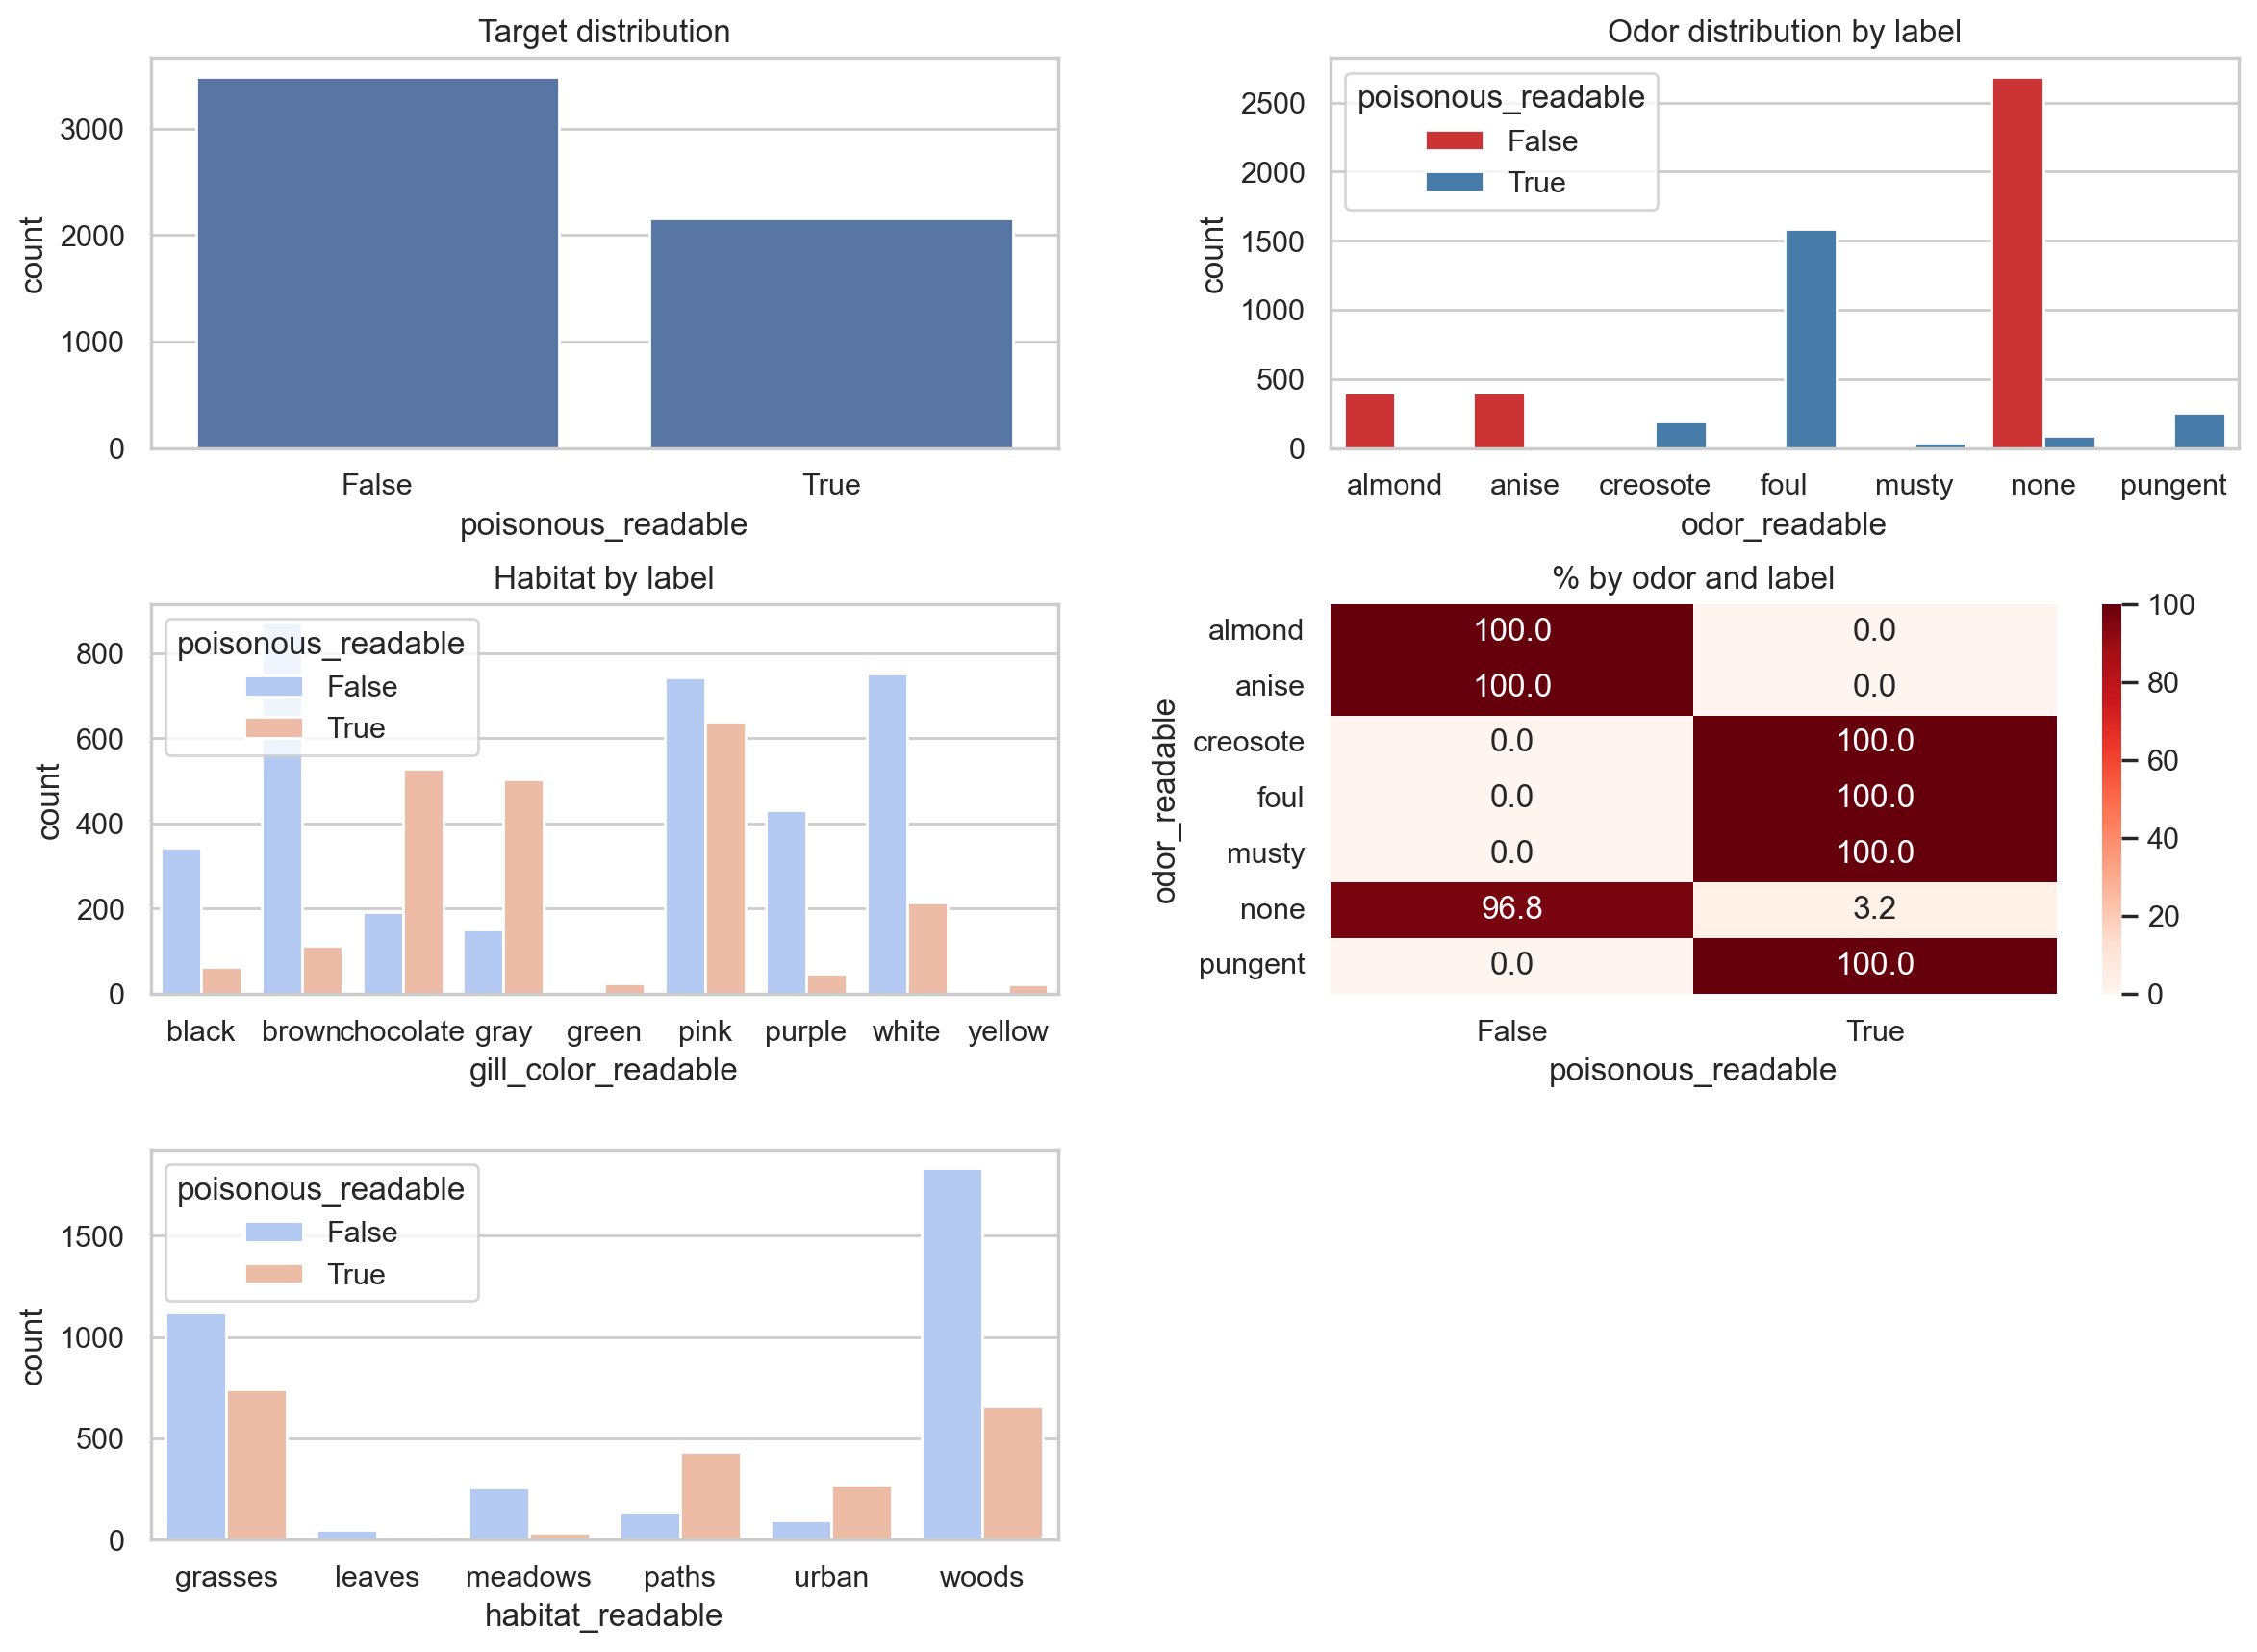

In [14]:
# EDA plots: label balance, odor vs label, gill color vs label, label-by-odor heatmap, missing values
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

# Ensure readable names exist (the notebook earlier maps these)
for col in ['poisonous_readable','odor_readable','gill_color_readable','stalk_root_readable']:
    if col not in data.columns:
        raise RuntimeError(f'Missing expected column: {col}')

fig = plt.figure(figsize=(14,10))
gs = fig.add_gridspec(3,2, hspace=0.4, wspace=0.3)

# 1) Target distribution
ax1 = fig.add_subplot(gs[0,0])
sns.countplot(data=data, x='poisonous_readable', ax=ax1)
ax1.set_title('Target distribution')

# 2) Odor distribution colored by label (stacked via countplot with hue)

ax2 = fig.add_subplot(gs[0,1])
sns.countplot(data=data, x='odor_readable', hue='poisonous_readable', palette='Set1', ax=ax2)
ax2.set_title('Odor distribution by label')

# 3) Gill color distribution by label (top 12 shown)

ax3 = fig.add_subplot(gs[1,0])
sns.countplot(data=data, x='gill_color_readable', hue='poisonous_readable', ax=ax3, palette='coolwarm')
ax3.set_title('Gill color by label')

# 4) Heatmap of proportion of poisonous by odor

pivot = (pd.crosstab(data['odor_readable'], data['poisonous_readable'], normalize='index') * 100).round(1)
ax4 = fig.add_subplot(gs[1,1])
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='Reds', ax=ax4)
ax4.set_title('% by odor and label')

# Also print top categorical cardinalities for quick reference
print('\nTop categorical cardinalities (number of categories):')
for c in data.columns:
    if pd.api.types.is_categorical_dtype(data[c]):
        print(f"{c}: {data[c].cat.categories.size}")

ax5 = fig.add_subplot(gs[2,0])
sns.countplot(data=data, x='habitat_readable', hue='poisonous_readable', ax=ax5, palette='coolwarm')
ax3.set_title('Habitat by label')


<Axes: title={'center': 'Bruise Distribution by Label'}, xlabel='bruises_readable', ylabel='count'>

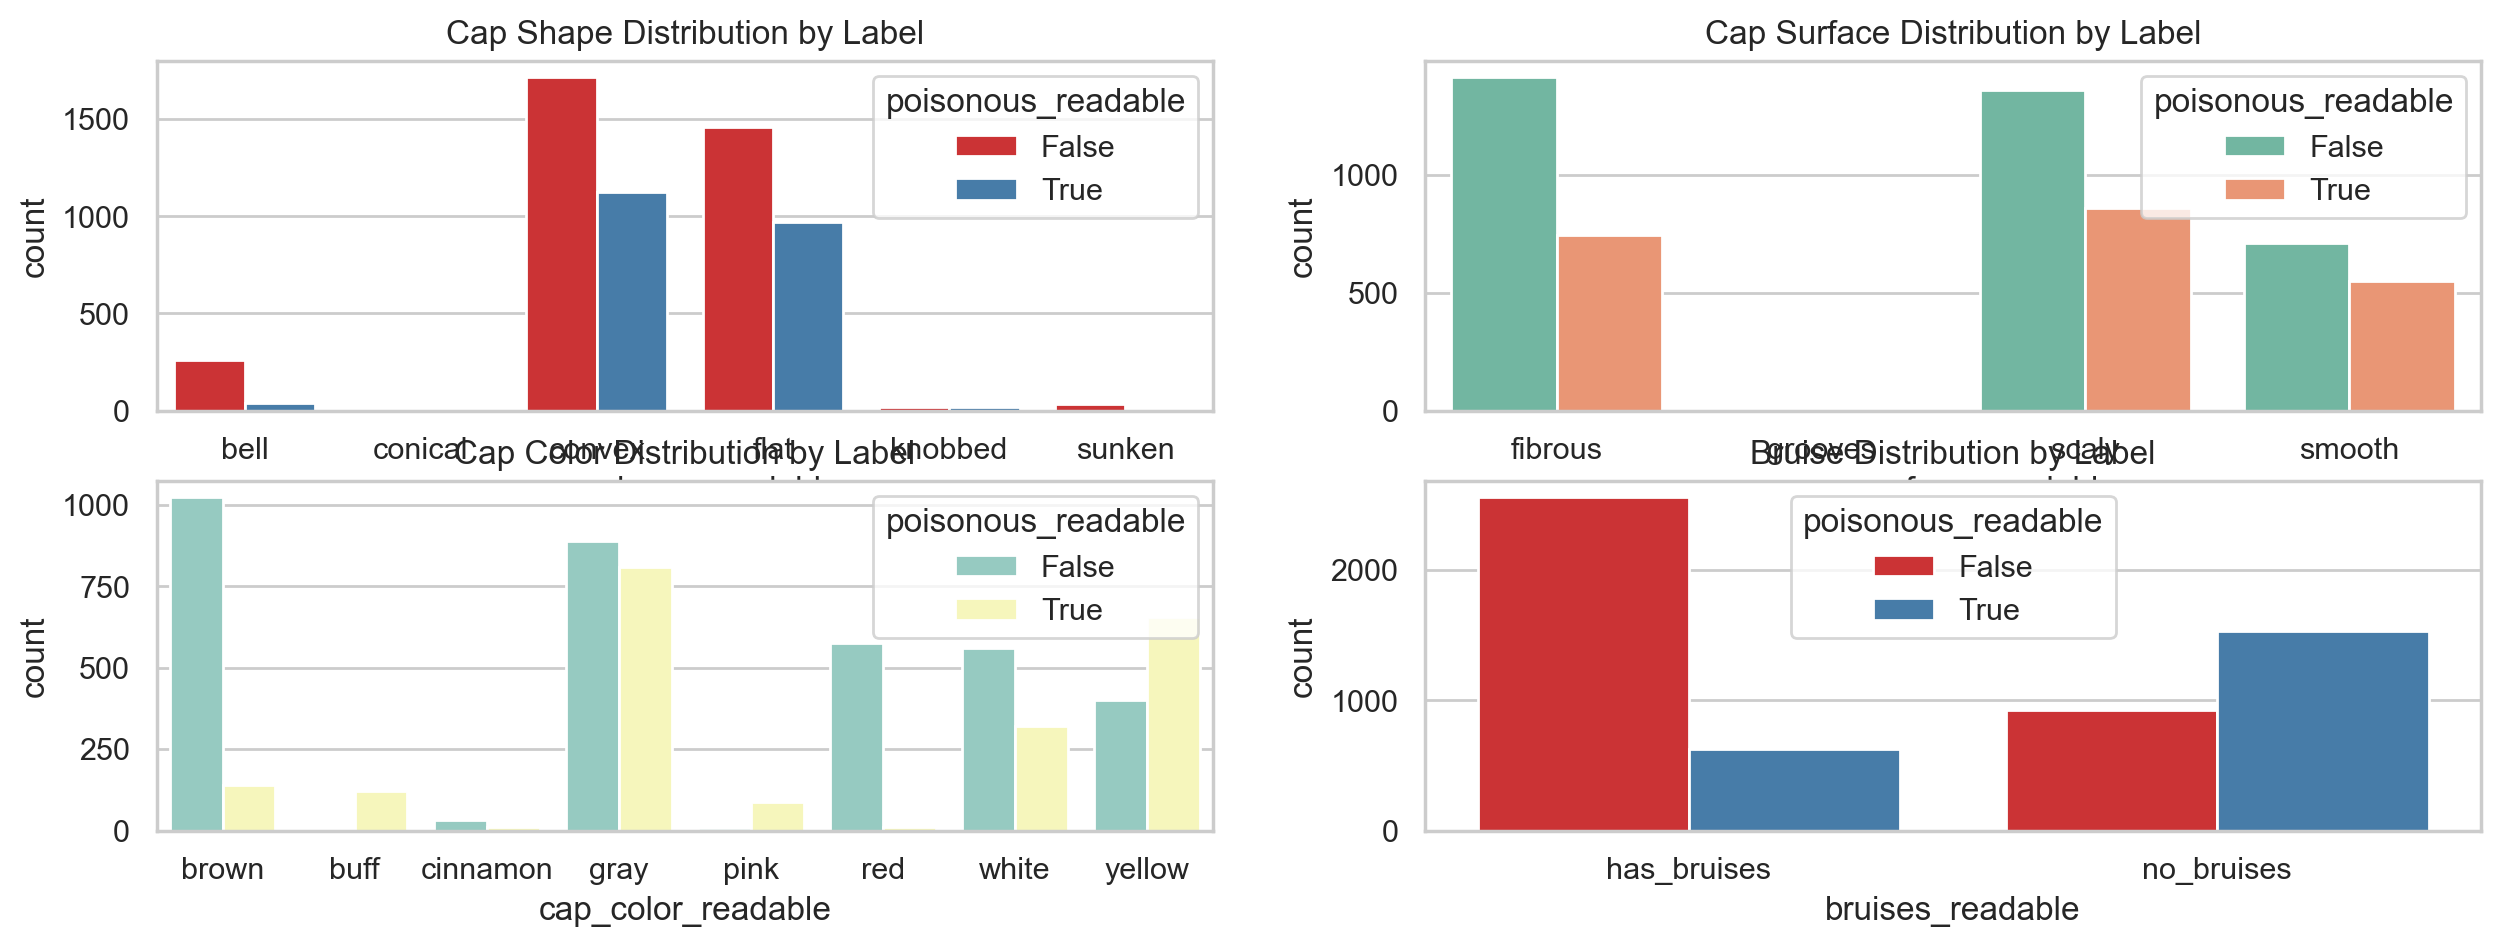

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5))

axes[0, 0].set_title("Cap Shape Distribution by Label")
sns.countplot(
    ax=axes[0, 0],
    data=data,
    x='cap_shape_readable',
    hue='poisonous_readable',
    palette='Set1'
)

axes[0, 1].set_title("Cap Surface Distribution by Label")
sns.countplot(
    ax=axes[0, 1],
    data=data,
    x='cap_surface_readable',
    hue='poisonous_readable',
    palette='Set2'
)

axes[1, 0].set_title("Cap Color Distribution by Label")
sns.countplot(
    ax=axes[1, 0],
    data=data,
    x='cap_color_readable',
    hue='poisonous_readable',
    palette='Set3'
)

axes[1, 1].set_title("Bruise Distribution by Label")
sns.countplot(
    ax=axes[1, 1],
    data=data,
    x='bruises_readable',
    hue='poisonous_readable',
    palette='Set1'
)

# Feature Engineering

In [17]:
# Feature engineering: create a few robust, low-risk engineered features
# - Turning bruises into a boolean feature
# - Creating integer features for ring_number, habitat, odor
# Save result to 'mushroom_engineered.csv' for downstream modeling
# important features: 'cap_shape_readable', 'cap_surface_readable', 'cap_color_readable', 'bruises_readable', 'stalk_root_readable'
#'veil_color_readable', 'odor_readable', 'habitat_readable', 'population_readable', 'gill_color_readable', 'ring_number_readable'
# 1) Converting bruises into a boolean
bruises_bool = pd.get_dummies(data['bruises_readable']).iloc[:, 0]
data = pd.concat([data, bruises_bool], axis=1)


# 2) Ring number into int
data['ring_number_readable'].astype('Int8')

# 3) Composite / interaction features
def interaction_features(df, feat1, feat2):
    name1 = feat1.replace('_readable', '')
    name2 = feat2.replace('_readable', '')
    new_col = f"{name1}_{name2}"
    df[new_col] = (data[feat1].astype(str).fillna('NA')+'_'+data[feat2].astype(str).fillna('NA'))

# cap_shape + cap_color 
interaction_features(data, 'cap_shape_readable', 'cap_color_readable')

# bruises + cap_surface
interaction_features(data, 'bruises_readable', 'cap_surface_readable')

# veil color + gill color as the veil is a protective layer for developing gills
interaction_features(data, 'gill_color_readable', 'veil_color_readable')

In [18]:
# Splitting data to prevent overfitting and data leakage when encoding
train_df, test_df = train_test_split(data, test_size=0.3, random_state=17)

In [19]:
# 4) Target encoding features to frequency of being poisonous
categorical_cols = [
    'cap_shape_readable', 'cap_surface_readable', 'cap_color_readable', 'stalk_root_readable', 
    'veil_color_readable', 'odor_readable', 'habitat_readable', 'population_readable', 'gill_color_readable'
]

interaction_cols = [
    'cap_shape_cap_color', 'bruises_cap_surface', 'gill_color_veil_color'
]

def target_encoding(train_df, test_df, cols, target, observed=True):
    """
    Adds target-encoding columns to df for each column in cols.
    Each new column is named <col>_te and contains the mean target per category.
    
    Parameters
    ----------
    train_df : pd.DataFrame
        Your training dataset
    test_df : pd.DataFrame
        Your validation dataset
    cols : list of str
        Categorical columns to encode
    target : str
        The name of the target column (must be numeric, e.g. 0/1)
    """
    for col in cols:
        
        col_name = col.replace('_readable', '')
        means = train_df.groupby(col, observed=observed)[target].mean()
        global_mean = train_df[target].mean()

        train_df[f'{col_name}_te'] = train_df[col].map(means).astype("float32")
        test_df[f'{col_name}_te'] = test_df[col].map(means).astype("float32")

    return train_df
    return test_df
    

target_encoding(train_df, test_df, categorical_cols, 'poisonous_readable')
target_encoding(train_df, test_df, interaction_cols, 'poisonous_readable')

,poisonous,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,cap_color_te,stalk_root_te,veil_color_te,odor_te,habitat_te,population_te,gill_color_te,cap_shape_cap_color_te,bruises_cap_surface_te,gill_color_veil_color_te
2227,e,x,f,w,f,n,f,w,b,k,...,0.357711,0.236842,0.38834,0.034591,0.409479,0.345315,0.146259,0.373860,0.605052,0.146259
1674,e,f,s,n,f,n,f,w,b,p,...,0.118750,0.236842,0.38834,0.034591,0.409479,0.345315,0.472024,0.110526,0.213855,0.472024
1150,e,f,s,w,f,n,f,w,b,p,...,0.357711,0.236842,0.38834,0.034591,0.409479,0.000000,0.472024,0.457711,0.213855,0.472024
2287,e,f,f,n,t,n,f,c,b,p,...,0.118750,0.497751,0.38834,0.034591,0.270224,0.395490,0.472024,0.110526,0.000000,0.472024
2240,e,x,y,e,t,n,f,c,b,w,...,0.022277,0.497751,0.38834,0.034591,0.270224,0.395490,0.234604,0.015000,0.114644,0.231222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,e,x,f,e,t,n,f,c,b,u,...,0.022277,0.497751,0.38834,0.034591,0.270224,0.395490,0.102639,0.015000,0.000000,0.102639
406,e,b,y,y,t,l,f,c,b,n,...,0.625169,0.074359,0.38834,0.000000,0.409479,0.000000,0.108271,0.011905,0.114644,0.108271
5929,p,b,s,w,t,n,f,c,b,w,...,0.357711,0.497751,0.38834,0.034591,0.409479,0.504545,0.234604,0.072917,0.587074,0.231222
2191,e,x,f,g,t,n,f,c,b,w,...,0.491942,0.497751,0.38834,0.034591,0.270224,0.395490,0.234604,0.503257,0.000000,0.231222


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3950 entries, 2227 to 2671
Data columns (total 62 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   poisonous                          3950 non-null   category
 1   cap_shape                          3950 non-null   category
 2   cap_surface                        3950 non-null   category
 3   cap_color                          3950 non-null   category
 4   bruises                            3950 non-null   category
 5   odor                               3950 non-null   category
 6   gill_attachment                    3950 non-null   category
 7   gill_spacing                       3950 non-null   category
 8   gill_size                          3950 non-null   category
 9   gill_color                         3950 non-null   category
 10  stalk_shape                        3950 non-null   category
 11  stalk_root                         3950 non-n

# Predicting and Assessing the Quality of Predictions

## Decision Tree Classifier

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model_features = [
    'cap_shape_te', 'cap_surface_te', 'cap_color_te', 'has_bruises', 'stalk_root_te', 'cap_shape_cap_color_te', 'bruises_cap_surface_te', 
    'gill_color_veil_color_te', 'veil_color_te', 'odor_te', 'habitat_te', 'population_te', 'gill_color_te', 'ring_number_readable'
]

#Preparing X and y for both the train and test df
X_train = train_df[[f for f in model_features]]
y_train = train_df['poisonous_readable']

X_test = test_df[[f for f in model_features]]
y_test = test_df['poisonous_readable']


clf = DecisionTreeClassifier(
    max_depth=6, random_state=17, min_samples_leaf=40 #approximately 1% of training samples
)

# Train a Decision Tree and evaluate with 5-fold CV on training data
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print('CV accuracy on training set:', scores.mean(), 'std:', scores.std())
clf.fit(X_train, y_train)

# Fit on full training data and evaluate on test set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Test set accuracy:', accuracy_score(y_test, y_pred))

# Save a small model-summary CSV with only the features used and label
MODEL_CSV = 'mushroom_model.csv'
pd.concat([train_df, test_df], axis=0).to_csv(MODEL_CSV, index=False)
print('Saved modeling CSV to', MODEL_CSV)

CV accuracy on training set: 0.9883544303797468 std: 0.005274092824303689
Test set accuracy: 0.9923258559622196
Saved modeling CSV to mushroom_model.csv


In [44]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "min_samples_leaf" : [10, 20, 40, 50, 100, 200],
    "max_depth" : [5, 10, 15]
}

clf = GridSearchCV(
    DecisionTreeClassifier(random_state=17),
    param_grid,
    n_jobs=-1,
    cv=5,
    verbose=True
)

clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'max_depth': 5, 'min_samples_leaf': 10} 0.9969620253164557


In [46]:
#Verifying accuracy to ensure there is no overfitting
y_pred = clf.predict(X_test)
print('Test set accuracy:', accuracy_score(y_test, y_pred))

Test set accuracy: 0.9958677685950413


## Random Forest

The goal of this section is to discover feature importances and improve the accuracy of predictions